In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import umap
import faiss
import sys
import time
import numpy as np
import plotly.express as px
from tqdm.auto import tqdm

In [84]:
class ClusteringLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, n_clusters, alpha=1.0, **kwargs ):
        super().__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha        
        
        self.size_in=size_in 
        weights = torch.Tensor(self.n_clusters, size_in)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.weights) # weight init

    def init_weights(self, init_clusters):
        self.weights = nn.Parameter(init_clusters)
    
    def forward(self, inputs):
        q = 1.0 / (1.0 + (torch.sum(torch.square(torch.unsqueeze(inputs, dim=1) - self.weights), dim=2) / self.alpha))
        q = torch.pow(q, (self.alpha + 1.0) / 2.0 ) 
        q = torch.transpose(torch.transpose(q, 0, 1) / torch.sum(q, dim=1), 0,1)
        return q

In [147]:
from sklearn.cluster import KMeans

class DCEC(nn.Module):
    def __init__(self, model, input_dim, hidden_dim, n_clusters):
        self.n_clusters = n_clusters
        super().__init__()
        self.ae = model
        #self.encoder = self.ae.encoder
        self.clustering_layer = ClusteringLayer(hidden_dim, self.n_clusters,)
    
    def init_clustering_layer(self, x):
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        #self.y_pred = kmeans.fit_predict(self.encoder(x))
        #self.y_pred_last = np.copy(self.y_pred)
        y_pred = kmeans.fit_predict(self.ae.encoder(x).detach().numpy())
        self.clustering_layer.init_weights(torch.from_numpy(kmeans.cluster_centers_)) # should be (self.n_clusters, input_dim)
        # self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
        return y_pred
    
    def target_distribution(self, q):
        weight = q ** 2 / torch.sum(q, dim=0)
        return torch.transpose(torch.transpose(weight, 0, 1) / torch.sum(weight, dim=1), 0,1)
    
    def forward(self, x):
        x = self.ae.encoder(x)
        x_clust = self.clustering_layer(x)
        x = self.ae.decoder(x)
        return x, x_clust

In [102]:
data = torch.rand(16,10)

In [143]:
encoder = Encoder(10, 2)
decoder = Decoder(2,10)
model = AE(encoder, decoder)

In [92]:
moder_1 = DCEC(model, input_dim=10, hidden_dim=2, n_clusters=2)

In [93]:
moder_1.init_clustering_layer(tensor)

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int32)

In [203]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score


def accuracy(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [229]:
from sklearn.datasets import make_blobs
data, y = make_blobs(n_samples=65536, centers=10, n_features=10,
                      random_state=0)
data = torch.from_numpy(data.astype("float32"))

In [230]:
loss_kld = torch.nn.KLDivLoss()
loss_mse = torch.nn.MSELoss()

encoder = Encoder(10, 2)#
decoder = Decoder(2,10)#
ae_model = AE(encoder, decoder)
pretrain_ae(ae_model, data)

Selected device: cuda
	 partial train loss (single batch): 32.316196
	 partial train loss (single batch): 9.915236
	 partial train loss (single batch): 34.642189
	 partial train loss (single batch): 14.833174
	 partial train loss (single batch): 37.947880
	 partial train loss (single batch): 9.240335
	 partial train loss (single batch): 7.629004
	 partial train loss (single batch): 23.305843
	 partial train loss (single batch): 26.085199
	 partial train loss (single batch): 26.148905
	 partial train loss (single batch): 27.992392
	 partial train loss (single batch): 21.653408
	 partial train loss (single batch): 21.940517
	 partial train loss (single batch): 23.196157
	 partial train loss (single batch): 38.097080
	 partial train loss (single batch): 11.409190
	 partial train loss (single batch): 7.331560
	 partial train loss (single batch): 28.897579
	 partial train loss (single batch): 42.496315
	 partial train loss (single batch): 21.302999
	 partial train loss (single batch): 21.64

In [234]:
model = DCEC(ae_model, input_dim=10, hidden_dim=2, n_clusters=10)
y_pred_last = model.init_clustering_layer(data)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-05)

In [235]:
from torch.utils.data import Dataset, DataLoader
batch_size = 16
#ds = Dataset(data)
dataloader = DataLoader(data, batch_size=batch_size)

In [237]:
update_interval = 4
tol = 1e-3

loss_val = -1
for ite, batch in enumerate(dataloader):
    if ite % update_interval == 0:
        with torch.no_grad():
            q_stack = []
            dataloader_ = DataLoader(data, batch_size=batch_size)
            for d in dataloader_:
                _, q = model(d)
                q_stack.append(q)
        q = torch.vstack(q_stack)
        p = model.target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            y_pred = y_pred.detach().numpy()
            acc = 0#np.round(accuracy(y, y_pred), 5)
            nmi = np.round(normalized_mutual_info_score(y, y_pred), 5)
            ari = np.round(adjusted_rand_score(y, y_pred), 5)
            #loss = np.round(loss, 5)
            #logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=loss[0], Lc=loss[1], Lr=loss[2])
            #logwriter.writerow(logdict)
            print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; loss=', loss_val)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    out, out_clust = model(batch)
    l1 = loss_kld(out_clust, p[batch_size * ite:batch_size * ite + batch_size])
    #l1.backward()
    l2 = loss_mse(out, batch)
    #l2.backward()
    l = l1 + l2
    loss_val = l.data.detach().numpy()
    optim.zero_grad()
    l.backward()
    optim.step()
    

Iter 0 : Acc 0 , nmi 0.99809 , ari 0.99878 ; loss= -1


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Iter 4 : Acc 0 , nmi 0.99826 , ari 0.99888 ; loss= 22.61609
delta_label  0.0002899169921875 < tol  0.001
Reached tolerance threshold. Stopping training.


In [222]:
y

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
# !pip install umap-learn[plot]
# !pip install tqdm
# !pip install plotly
# !pip install faiss-cpu

In [45]:
def ivecs_read(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()


def fvecs_read(fname):
    return ivecs_read(fname).view('float32')


def load_sift1M():
    print("Loading sift1M...", end='', file=sys.stderr)
    xt = fvecs_read("dataset/SIFT1M/sift_learn.fvecs")
    xb = fvecs_read("dataset/SIFT1M/sift_base.fvecs")
    xq = fvecs_read("dataset/SIFT1M/sift_query.fvecs")
    gt = ivecs_read("dataset/SIFT1M/sift_groundtruth.ivecs")
    print("done", file=sys.stderr)

    return xb, xq, xt, gt


def evaluate(index, xq, gt, k):
    nq = xq.shape[0]
    t0 = time.time()
    D, I = index.search(xq, k)  # noqa: E741
    t1 = time.time()

    recalls = {}
    i = 1
    while i <= k:
        recalls[i] = (I[:, :i] == gt[:, :1]).sum() / float(nq)
        i *= 10

    return (t1 - t0) * 1000.0 / nq, recalls

In [48]:
xb, xq, xt, gt = load_sift1M()
nq, d = xq.shape

k = 32

for nbits in [4, 6, 8, 10, 12]: # 
    index = faiss.IndexPQ(d, 8, nbits)
    index.train(xt)
    index.add(xb)

    t, r = evaluate(index, xq, gt, k)
    print("\t %7.3f ms per query, R@1 %.4f" % (t, r[1]))
    del index

Loading sift1M...done


	   1.413 ms per query, R@1 0.0258
	   1.699 ms per query, R@1 0.1129
	   0.444 ms per query, R@1 0.2252
	   2.190 ms per query, R@1 0.3200


WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points


	   2.582 ms per query, R@1 0.3932


In [53]:
# https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [31]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        #x = self.encoder_cnn(x)
        #x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, output_dim),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        #x = self.unflatten(x)
        #x = self.decoder_conv(x)
        #x = torch.sigmoid(x)
        return x

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [71]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
  )
)

In [ ]:
# Set train mode for both the encoder and the decoder
encoder.train()
decoder.train()
train_loss = []
# Iterate the dataloader (we do not need the label values, this is unsupervised learning)
for image_batch in zip(*(iter(torch.Tensor(xt)),) * 10): # with "_" we just ignore the labels (the second element of the dataloader tuple)
    # Move tensor to the proper device
    image_batch = torch.stack(image_batch).to(device)
    # Encode data
    encoded_data = encoder(image_batch)
    # Decode data
    decoded_data = decoder(encoded_data)
    # Evaluate loss
    loss = loss_fn(decoded_data, image_batch)
    # Backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()
    # Print batch loss
    print('\t partial train loss (single batch): %f' % (loss.data))
    train_loss.append(loss.detach().cpu().numpy())

In [214]:
def pretrain_ae(model, data):
    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr= 0.001

    ### Set the random seed for reproducible results
    torch.manual_seed(0)

    ### Initialize the two networks
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)

    # Check if the GPU is available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f'Selected device: {device}')

    # Move both the encoder and the decoder to the selected device
    #encoder.to(device)
    #decoder.to(device)
    
    dataloader = DataLoader(data)
    model.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for i, batch in enumerate(dataloader): # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        #image_batch = torch.stack(image_batch).to(device)
        # Encode data
        out = model(batch) 
        # Evaluate loss
        loss = loss_fn(out, batch)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Print batch loss
        if i % 100 == 0:
            print('\t partial train loss (single batch): %f' % (loss.data))
        #train_loss.append(loss.detach().cpu().numpy())

In [ ]:

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
#encoded_samples

In [91]:
def apply_encoder(encoder, vectors, slice_, device="cuda"):
    if not isinstance(vectors, torch.Tensor):
        vectors = torch.Tensor(vectors)
    # vectors = vectors.to(device)
    new_vec = []
    encoder.eval()
    for vectors_batch in zip(*(iter(vectors),) * slice_):
        vectors_batch = torch.stack(vectors_batch).to(device)
        with torch.no_grad():
            encoded_vec  = encoder(vectors_batch)
        # Append to list
        encoded_vec = encoded_vec.cpu().numpy()
        new_vec.append(encoded_vec)
    return np.vstack(new_vec)

In [94]:
xb_.shape

(1000000, 32)

In [99]:
xb, xq, xt, gt = load_sift1M()

xb = apply_encoder(encoder, xb, slice_=10)
xq = apply_encoder(encoder, xq, slice_=10)
xt = apply_encoder(encoder, xt, slice_=10)
#gt = apply_encoder(encoder, gt, slice_=10)

nq, d = xq.shape

k = 32

for nbits in [4, 6, 8, 10, 12]: # 
    index = faiss.IndexPQ(d, 8, nbits)
    index.train(xt)
    index.add(xb)

    t, r = evaluate(index, xq, gt, k)
    print("\t %7.3f ms per query, R@1 %.4f" % (t, r[1]))
    del index

Loading sift1M...done


	   1.068 ms per query, R@1 0.0461
	   1.237 ms per query, R@1 0.1299
	   0.326 ms per query, R@1 0.2061
	   1.662 ms per query, R@1 0.2687


WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points
WARNING clustering 100000 points to 4096 centroids: please provide at least 159744 training points


	   2.011 ms per query, R@1 0.3124


In [ ]:
def evaluate(index):
    # for timing with a single core
    # faiss.omp_set_num_threads(1)

    t0 = time.time()
    D, I = index.search(xq, k)
    t1 = time.time()

    missing_rate = (I == -1).sum() / float(k * nq)
    recall_at_1 = (I == gt[:, :1]).sum() / float(nq)
    print("\t %7.3f ms per query, R@1 %.4f, missing rate %.4f" % (
        (t1 - t0) * 1000.0 / nq, recall_at_1, missing_rate))

In [109]:
print("Testing HNSW Flat")

index = faiss.IndexHNSWFlat(d, 32)

# training is not needed

# this is the default, higher is more accurate and slower to
# construct
index.hnsw.efConstruction = 40

print("add")
# to see progress
index.verbose = False
index.add(xb)

print("search")
for efSearch in 16, 32, 64, 128, 256:
    for bounded_queue in [True, False]:
        #print("efSearch", efSearch, "bounded queue", bounded_queue, end=' ')
        index.hnsw.search_bounded_queue = bounded_queue
        index.hnsw.efSearch = efSearch
        t, r = evaluate(index, xq, gt, k)
        print("\t %7.3f ms per query, R@1 %.4f" % (t, r[1]))

Testing HNSW Flat
add
search
	   0.010 ms per query, R@1 0.3737
	   0.015 ms per query, R@1 0.3804
	   0.016 ms per query, R@1 0.3798
	   0.015 ms per query, R@1 0.3804
	   0.026 ms per query, R@1 0.3825
	   0.023 ms per query, R@1 0.3831
	   0.048 ms per query, R@1 0.3826
	   0.046 ms per query, R@1 0.3833
	   0.094 ms per query, R@1 0.3826
	   0.089 ms per query, R@1 0.3835


In [105]:
d = 32
nlist = 32
quantizer = faiss.IndexFlatL2(d)
indexivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, int(d / 8), 8)
pq = faiss.ProductQuantizer(d, int(d / 8), 8)

indexivfpq.pq = pq
indexivfpq.is_trained = False
#indexivfpq.by_residual = False

indexivfpq.train(xt)
indexivfpq.add(xb)
indexivfpq.nprobe = 4

D, I = indexivfpq.search(xq, 3)

In [107]:
evaluate(indexivfpq, xq, gt, k)

(0.32700114250183104, {1: 0.108, 10: 0.3347})

In [4]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [5]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.213514
	 partial train loss (single batch): 0.206204
	 partial train loss (single batch): 0.201653
	 partial train loss (single batch): 0.196994
	 partial train loss (single batch): 0.194070
	 partial train loss (single batch): 0.190899
	 partial train loss (single batch): 0.189039
	 partial train loss (single batch): 0.185999
	 partial train loss (single batch): 0.184024
	 partial train loss (single batch): 0.182336
	 partial train loss (single batch): 0.180462
	 partial train loss (single batch): 0.178425
	 partial train loss (single batch): 0.177136
	 partial train loss (single batch): 0.175141
	 partial train loss (single batch): 0.173830
	 partial train loss (single batch): 0.171633
	 partial train loss (single batch): 0.170433
	 partial train loss (single batch): 0.168821
	 partial train loss (single batch): 0.167271
	 partial train loss (single batch): 0.166282
	 partial train loss (single batch): 0.163936
	 partial train loss (single batch

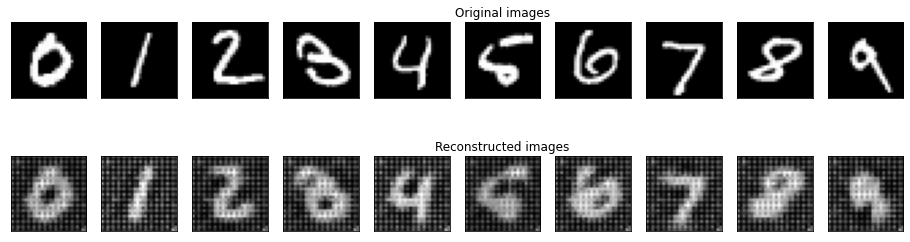

	 partial train loss (single batch): 0.057481
	 partial train loss (single batch): 0.058274
	 partial train loss (single batch): 0.058174
	 partial train loss (single batch): 0.057453
	 partial train loss (single batch): 0.057798
	 partial train loss (single batch): 0.057395
	 partial train loss (single batch): 0.057123
	 partial train loss (single batch): 0.055811
	 partial train loss (single batch): 0.055430
	 partial train loss (single batch): 0.055696
	 partial train loss (single batch): 0.055103
	 partial train loss (single batch): 0.054999
	 partial train loss (single batch): 0.056320
	 partial train loss (single batch): 0.053689
	 partial train loss (single batch): 0.053775
	 partial train loss (single batch): 0.054083
	 partial train loss (single batch): 0.053469
	 partial train loss (single batch): 0.052660
	 partial train loss (single batch): 0.052797
	 partial train loss (single batch): 0.053573
	 partial train loss (single batch): 0.052196
	 partial train loss (single batch

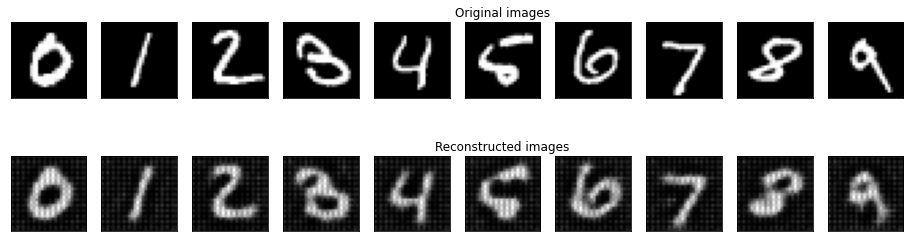

	 partial train loss (single batch): 0.025169
	 partial train loss (single batch): 0.025056
	 partial train loss (single batch): 0.025600
	 partial train loss (single batch): 0.025544
	 partial train loss (single batch): 0.025611
	 partial train loss (single batch): 0.025267
	 partial train loss (single batch): 0.025233
	 partial train loss (single batch): 0.024487
	 partial train loss (single batch): 0.024455
	 partial train loss (single batch): 0.024567
	 partial train loss (single batch): 0.024122
	 partial train loss (single batch): 0.024353
	 partial train loss (single batch): 0.025230
	 partial train loss (single batch): 0.023993
	 partial train loss (single batch): 0.023948
	 partial train loss (single batch): 0.024524
	 partial train loss (single batch): 0.024390
	 partial train loss (single batch): 0.023733
	 partial train loss (single batch): 0.024047
	 partial train loss (single batch): 0.024224
	 partial train loss (single batch): 0.024561
	 partial train loss (single batch

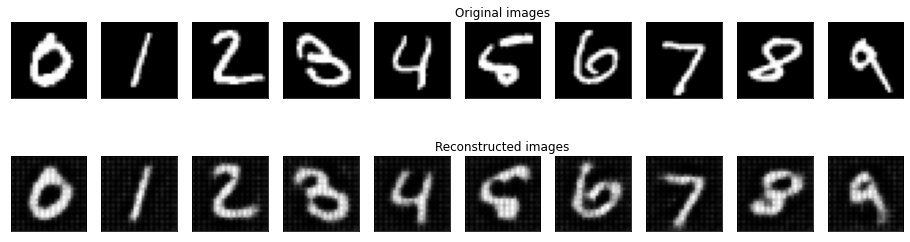

	 partial train loss (single batch): 0.016054
	 partial train loss (single batch): 0.016142
	 partial train loss (single batch): 0.016495
	 partial train loss (single batch): 0.016791
	 partial train loss (single batch): 0.016822
	 partial train loss (single batch): 0.016337
	 partial train loss (single batch): 0.016447
	 partial train loss (single batch): 0.016010
	 partial train loss (single batch): 0.015848
	 partial train loss (single batch): 0.016218
	 partial train loss (single batch): 0.015682
	 partial train loss (single batch): 0.015896
	 partial train loss (single batch): 0.016554
	 partial train loss (single batch): 0.015741
	 partial train loss (single batch): 0.015763
	 partial train loss (single batch): 0.016308
	 partial train loss (single batch): 0.015752
	 partial train loss (single batch): 0.016020
	 partial train loss (single batch): 0.015540
	 partial train loss (single batch): 0.015970
	 partial train loss (single batch): 0.016436
	 partial train loss (single batch

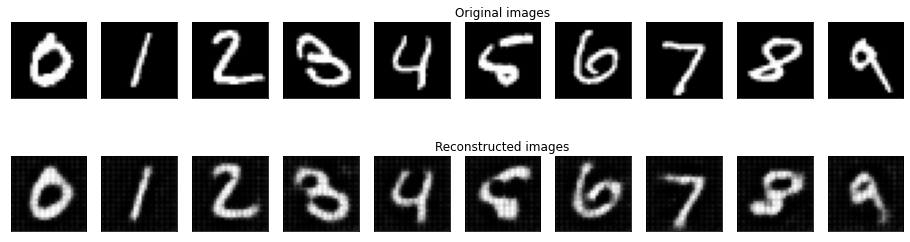

	 partial train loss (single batch): 0.012626
	 partial train loss (single batch): 0.012554
	 partial train loss (single batch): 0.012869
	 partial train loss (single batch): 0.013103
	 partial train loss (single batch): 0.013347
	 partial train loss (single batch): 0.012809
	 partial train loss (single batch): 0.012987
	 partial train loss (single batch): 0.012669
	 partial train loss (single batch): 0.012499
	 partial train loss (single batch): 0.012656
	 partial train loss (single batch): 0.012445
	 partial train loss (single batch): 0.012396
	 partial train loss (single batch): 0.013089
	 partial train loss (single batch): 0.012924
	 partial train loss (single batch): 0.012573
	 partial train loss (single batch): 0.012944
	 partial train loss (single batch): 0.012861
	 partial train loss (single batch): 0.012807
	 partial train loss (single batch): 0.012345
	 partial train loss (single batch): 0.012953
	 partial train loss (single batch): 0.013268
	 partial train loss (single batch

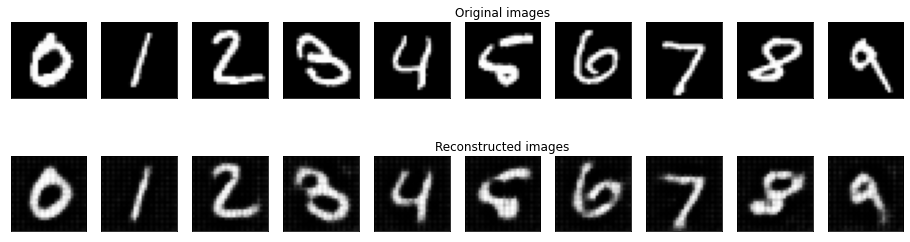

	 partial train loss (single batch): 0.010638
	 partial train loss (single batch): 0.010889
	 partial train loss (single batch): 0.011101
	 partial train loss (single batch): 0.011327
	 partial train loss (single batch): 0.011520
	 partial train loss (single batch): 0.011318
	 partial train loss (single batch): 0.011299
	 partial train loss (single batch): 0.010987
	 partial train loss (single batch): 0.010954
	 partial train loss (single batch): 0.011045
	 partial train loss (single batch): 0.010789
	 partial train loss (single batch): 0.010721
	 partial train loss (single batch): 0.011661
	 partial train loss (single batch): 0.011190
	 partial train loss (single batch): 0.010894
	 partial train loss (single batch): 0.011677
	 partial train loss (single batch): 0.011053
	 partial train loss (single batch): 0.011071
	 partial train loss (single batch): 0.010968
	 partial train loss (single batch): 0.011101
	 partial train loss (single batch): 0.011824
	 partial train loss (single batch

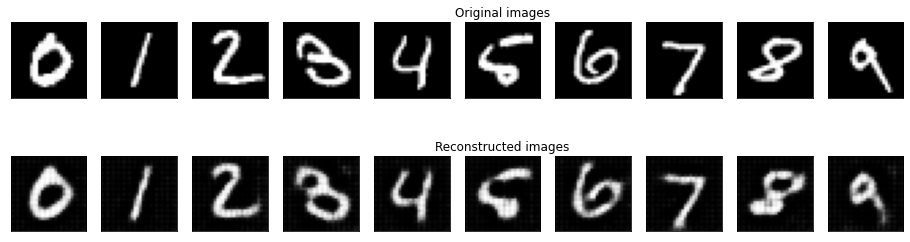

	 partial train loss (single batch): 0.010231
	 partial train loss (single batch): 0.010261
	 partial train loss (single batch): 0.010503
	 partial train loss (single batch): 0.010841
	 partial train loss (single batch): 0.010681
	 partial train loss (single batch): 0.010880
	 partial train loss (single batch): 0.010317
	 partial train loss (single batch): 0.010175
	 partial train loss (single batch): 0.010056
	 partial train loss (single batch): 0.010177
	 partial train loss (single batch): 0.010338
	 partial train loss (single batch): 0.009676
	 partial train loss (single batch): 0.010907
	 partial train loss (single batch): 0.009895
	 partial train loss (single batch): 0.010305
	 partial train loss (single batch): 0.010401
	 partial train loss (single batch): 0.009672
	 partial train loss (single batch): 0.010187
	 partial train loss (single batch): 0.009590
	 partial train loss (single batch): 0.010055
	 partial train loss (single batch): 0.010361
	 partial train loss (single batch

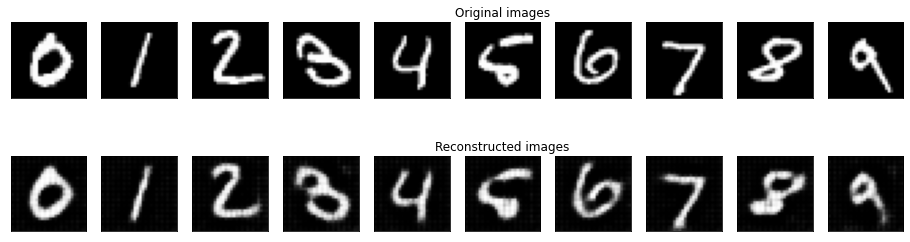

	 partial train loss (single batch): 0.009120
	 partial train loss (single batch): 0.009510
	 partial train loss (single batch): 0.009356
	 partial train loss (single batch): 0.009747
	 partial train loss (single batch): 0.009813
	 partial train loss (single batch): 0.009657
	 partial train loss (single batch): 0.009438
	 partial train loss (single batch): 0.009226
	 partial train loss (single batch): 0.009085
	 partial train loss (single batch): 0.009466
	 partial train loss (single batch): 0.009175
	 partial train loss (single batch): 0.009019
	 partial train loss (single batch): 0.009876
	 partial train loss (single batch): 0.009115
	 partial train loss (single batch): 0.009250
	 partial train loss (single batch): 0.009632
	 partial train loss (single batch): 0.008995
	 partial train loss (single batch): 0.009340
	 partial train loss (single batch): 0.008906
	 partial train loss (single batch): 0.009202
	 partial train loss (single batch): 0.009695
	 partial train loss (single batch

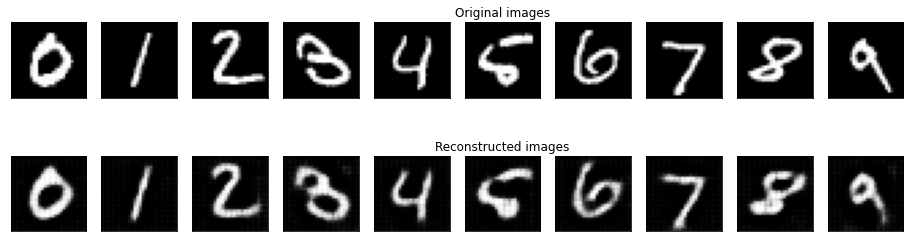

	 partial train loss (single batch): 0.009135
	 partial train loss (single batch): 0.009373
	 partial train loss (single batch): 0.009113
	 partial train loss (single batch): 0.009541
	 partial train loss (single batch): 0.009485
	 partial train loss (single batch): 0.009461
	 partial train loss (single batch): 0.009178
	 partial train loss (single batch): 0.008889
	 partial train loss (single batch): 0.008864
	 partial train loss (single batch): 0.009041
	 partial train loss (single batch): 0.008839
	 partial train loss (single batch): 0.008677
	 partial train loss (single batch): 0.009328
	 partial train loss (single batch): 0.008815
	 partial train loss (single batch): 0.008947
	 partial train loss (single batch): 0.009129
	 partial train loss (single batch): 0.008708
	 partial train loss (single batch): 0.008846
	 partial train loss (single batch): 0.008604
	 partial train loss (single batch): 0.008746
	 partial train loss (single batch): 0.009356
	 partial train loss (single batch

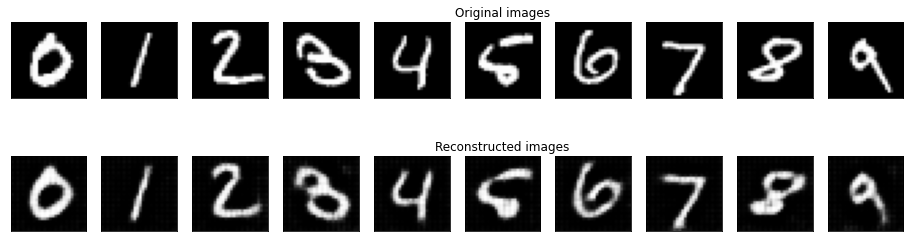

	 partial train loss (single batch): 0.008414
	 partial train loss (single batch): 0.008641
	 partial train loss (single batch): 0.008804
	 partial train loss (single batch): 0.008919
	 partial train loss (single batch): 0.009004
	 partial train loss (single batch): 0.009187
	 partial train loss (single batch): 0.008528
	 partial train loss (single batch): 0.008550
	 partial train loss (single batch): 0.008395
	 partial train loss (single batch): 0.008589
	 partial train loss (single batch): 0.008549
	 partial train loss (single batch): 0.008212
	 partial train loss (single batch): 0.008982
	 partial train loss (single batch): 0.008389
	 partial train loss (single batch): 0.008489
	 partial train loss (single batch): 0.008632
	 partial train loss (single batch): 0.008286
	 partial train loss (single batch): 0.008391
	 partial train loss (single batch): 0.008142
	 partial train loss (single batch): 0.008273
	 partial train loss (single batch): 0.008937
	 partial train loss (single batch

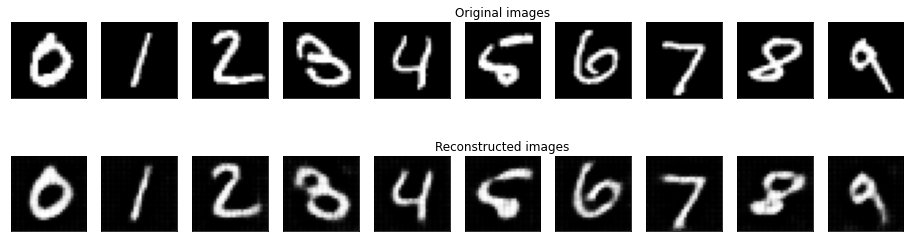

In [30]:
num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,
    train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss), end="\r")
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=10)

In [31]:

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
#encoded_samples

  0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
samples = encoded_samples.iloc[:,:-1].to_numpy()

In [33]:
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(samples)

In [23]:
px.scatter(encoded_samples, x=embedding[:,0], y=embedding[:, 1], 
           color=encoded_samples.label.astype(str).to_list(), opacity=0.7)

In [34]:
px.scatter(encoded_samples, x=embedding[:,0], y=embedding[:, 1], 
           color=encoded_samples.label.astype(str).to_list(), opacity=0.7)